# Base Model

Blog: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8

Source code: https://github.com/hlamba28/Automatic-Image-Captioning

In [83]:
%load_ext autoreload
%autoreload 2

import pickle
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from helper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
FLICKR8K_TEXT = '../Flickr8k_text'
FLICKR8K_DATASET = '../Flicker8k_Dataset'

## 1 - Load, clean, save captions


In [85]:
doc = load_doc(f'{FLICKR8K_TEXT}/Flickr8k.token.txt')
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


As we can see from the output, we have in each line  the image id, the caption number and the caption itself.

We want to spilt each line into key value pairs, with the keys being image id's and the values being a list of captions 0-4.

In [86]:
# create a map of image ids with related descriptions
descriptions = load_descriptions(doc)
print('Loaded: ', len(descriptions))

Loaded:  8092


We need to remove punctuation and anything else not words, overwrite descriptions dictionary with cleaned version.

In [11]:
clean_descriptions(descriptions)
save_descriptions(descriptions, 'descriptions.txt')

## 2 - Extract image features

The CNN prebuilt model used is InceptionV3, with imagenet weights.

In [28]:
train_img_paths, dev_img_paths, test_img_paths = load_train_dev_test_image_paths(
    f'{FLICKR8K_DATASET}/*.jpg', 
    FLICKR8K_TEXT,
)

In [ ]:
from keras.applications.inception_v3 import InceptionV3

# Load the inception v3 model
inception_v3_model = InceptionV3(weights='imagenet')

The last layer of InceptionV3 is a dense layer of size 2048.

In [21]:
from keras.models import Model

# Create a new model, by removing the last layer (output layer) from the inception v3
image_features_extract_model = Model(inception_v3_model.input, inception_v3_model.layers[-2].output)

We need to run our training images through model_new (forward pass) to get our feature vectors 
and reshape to (2048, ) to input to the caption model.

Encode training images - THIS TAKE A LONG TIME, RUN ON GPU if possible

In [17]:
image_encodings_train = extract_features_from_images(
    image_path_list=train_img_paths,
    cnn_model=image_features_extract_model,
    target_size=(299, 299),
    save_file_path='Pickle/encoded_train_images.pkl',
)

Extracting features from images: 100%|██████████| 6000/6000 [02:26<00:00, 41.09it/s]


Image encodings saved at: Pickle/encoded_train_images.pkl


In [18]:
image_encodings_dev = extract_features_from_images(
    image_path_list=dev_img_paths,
    cnn_model=image_features_extract_model,
    target_size=(299, 299),
    save_file_path='Pickle/encoded_dev_images.pkl',
)

Extracting features from images: 100%|██████████| 1000/1000 [00:23<00:00, 42.68it/s]

Image encodings saved at: Pickle/encoded_dev_images.pkl


In [19]:
image_encodings_test = extract_features_from_images(
    image_path_list=test_img_paths,
    cnn_model=image_features_extract_model,
    target_size=(299, 299),
    save_file_path='Pickle/encoded_test_images.pkl',
)

Extracting features from images: 100%|██████████| 1000/1000 [00:23<00:00, 42.68it/s]

Image encodings saved at: Pickle/encoded_test_images.pkl


## 4 - Load and Preprocess clean data


Wrap with START and END tokens for each image caption in the train dataset

In [29]:
train_image_ids = [img_path.split('/')[-1].split('.')[0] for img_path in train_img_paths]
train_descriptions = add_start_end_token('descriptions.txt', train_image_ids)

train_image_features = pickle.load(open("train_image_encodings.pickle", "rb"))
print('Photos: train=%d' % len(train_image_features))

Photos: train=6000


In [30]:
dev_image_ids = [img_path.split('/')[-1].split('.')[0] for img_path in dev_img_paths]
dev_descriptions = add_start_end_token('descriptions.txt', dev_image_ids)

dev_image_features = pickle.load(open("dev_image_encodings.pickle", "rb"))
print('Photos: dev=%d' % len(dev_image_features))

Photos: dev=1000


In [5]:
with open('../dev_image_encodings.pkl', 'wb') as f:
    pickle.dump(dev_image_features, f, protocol=2)

In [8]:
import json
with open('../dev_descriptions.json', 'w') as f:
    json.dump(dev_descriptions, f)

In [31]:
from collections import Counter

all_train_captions = [desc 
                      for desc_list in train_descriptions.values() 
                      for desc in desc_list]

# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = Counter([word for caption in all_train_captions for word in caption.split(' ')])
vocabs = [word for word, count in word_counts.items() if count >= word_count_threshold]
print(f'Reduced vocab size from {len(word_counts)} -> {len(vocabs)}')

Reduced vocab size from 7578 -> 1651


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

top_k = 1651
tokenizer = Tokenizer(num_words=1651, 
                      oov_token='<unk>', 
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_train_captions)
max_length = max(len(t) for t in tokenizer.texts_to_sequences(all_train_captions))
vocab_size = top_k + 1

## 5 - Build Base model

In [8]:
from keras.layers import LSTM, Embedding, Dense, Flatten, Dropout
from keras.layers.merge import add
from keras.models import Model
from keras import Input

# feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
base_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
base_model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(base_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      422912      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

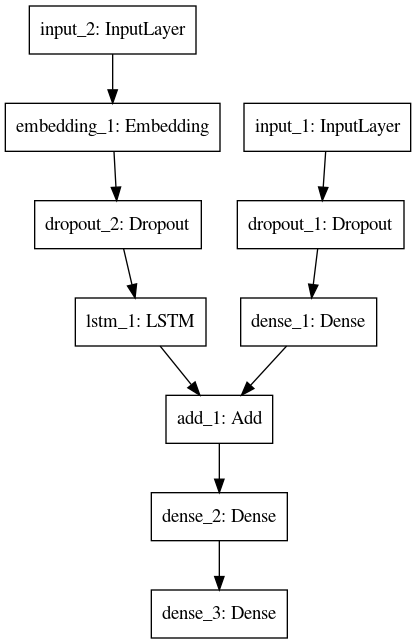

In [9]:
from keras.utils import plot_model

plot_model(base_model)

## 6 - Train model

In [136]:
from tensorflow.keras.preprocessing.text import Tokenizer


from collections import Counter

all_train_captions = [desc 
                      for desc_list in train_descriptions.values() 
                      for desc in desc_list]

top_k = 1651
tokenizer = Tokenizer(num_words=1651, 
                      oov_token='<unk>', 
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_train_captions)
max_length = max(len(t) for t in tokenizer.texts_to_sequences(all_train_captions))
vocab_size = top_k + 1


def data_generator(
    descriptions: Dict[str, List], image_features: Dict[str, np.array], tokenizer,
    max_length: int, vocab_size: int, num_images_per_epoch: int
):
    """
    The data generator will yield:
        - X1: the extract features of an image (image_feature),
        - X2: the accumulated word sequences of a description related to the image (in_seq)
        -  y: the next encoded word sequence (out_seq)
    X2 is padded with zeros up to max_length in order to keep the same dimension for all X2s.
    """
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for image_id, desc_list in descriptions.items():
            n += 1
            image_feature = image_features[image_id]
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(image_feature)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == num_images_per_epoch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n = 0

epochs = 20
number_pics_per_batch = 30
train_steps = len(train_descriptions) // number_pics_per_batch
validation_steps = len(dev_descriptions) // number_pics_per_batch

history = list()

for i in range(epochs):
    train_generator = data_generator(
        train_descriptions, 
        train_image_features, 
        tokenizer,
        max_length, 
        vocab_size,
        number_pics_per_batch,
    )
    dev_generator = data_generator(
        dev_descriptions, 
        dev_image_features,
        tokenizer,
        max_length,
        vocab_size,
        number_pics_per_batch,
    )
    hist = base_model.fit(
        train_generator, 
        validation_data=dev_generator, 
        epochs=1, 
        steps_per_epoch=train_steps,
        validation_steps=validation_steps,
        verbose=1,
    )
    history.append({
        'loss': hist.history['loss'], 
        'val_loss': hist.history['val_loss'],
    })
    base_model.save('./base_model_weights/model_' + str(i) + '.h5')

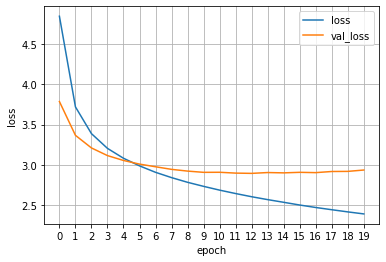

In [137]:
import matplotlib.pyplot as plt 

hist_df = pd.DataFrame(history)
plt.plot(list(hist_df['loss']), label='loss')
plt.plot(list(hist_df['val_loss']), label='val_loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0, epochs, 1))
plt.grid()
plt.show()

## 7 - Evaluate model



In [32]:
def flatten(lst):
    return sum(([x] if not isinstance(x, list) else flatten(x) for x in lst), [])

def generate_caption_beam(pred_model, caption_train_tokenizer, photo, max_length, vocab_size, beam_width):
    sequence = caption_train_tokenizer.texts_to_sequences(['startseq'])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    model_softMax_output = np.squeeze(pred_model.predict([photo,sequence], verbose=0))
    most_likely_seq=np.argsort(model_softMax_output)[-beam_width:]
    most_likely_prob=np.log(model_softMax_output[most_likely_seq])


    most_likely_cap = list()
    for j in range(beam_width):
        most_likely_cap.append(list())
        most_likely_cap[j] =[[caption_train_tokenizer.index_word[most_likely_seq[j]]]]

    for i in range(max_length):    
        temp_prob = np.zeros((beam_width, vocab_size))
        for j in range(beam_width):
            if most_likely_cap[j][-1] != ['endseq']: #if not terminated
                num_words = len(most_likely_cap[j])
                sequence = caption_train_tokenizer.texts_to_sequences(most_likely_cap[j])
                sequence = pad_sequences(np.transpose(sequence), maxlen=max_length)
                model_softMax_output = pred_model.predict([photo, sequence], verbose=0)
                temp_prob[j,] = (1/(num_words)) *(most_likely_prob[j]*(num_words-1) + np.log(model_softMax_output)) #update most likily prob
            else:
                temp_prob[j,] = most_likely_prob[j] + np.zeros(vocab_size) - np.inf
                temp_prob[j,0] = most_likely_prob[j]


        x_idx, y_idx = np.unravel_index(temp_prob.flatten().argsort()[-beam_width:], temp_prob.shape)

        most_likely_cap_temp = list()
        for j in range(beam_width):
            most_likely_prob[j] = temp_prob[x_idx[j],y_idx[j]]
            most_likely_cap_temp.append(list())
            most_likely_cap_temp[j] = most_likely_cap[x_idx[j]].copy()
            if most_likely_cap_temp[j][-1] != ['endseq']:
                most_likely_cap_temp[j].append([caption_train_tokenizer.index_word[y_idx[j]]])

        most_likely_cap = most_likely_cap_temp.copy()

        finished = True
        for j in range(beam_width):
            if most_likely_cap_temp[j][-1] != ['endseq']:
                finished = False

        if finished == True:
            break

    final_caption = list()

    for j in range(beam_width):
        final_caption.append(' '.join(flatten(most_likely_cap[j][0:-1])))


    return final_caption, most_likely_prob

In [33]:
def greedySearch(photo, model):
    in_text = 'startseq'
    for i in range(max_length):
#         sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

### BLEU

The primary programming task for a BLEU implementor is to compare n-grams of the candidate with the n-grams of the reference translation and count the number of matches. These matches are position-independent. The more the matches, the better the candidate translation is.

Cumulative N-Gram Scores
Cumulative scores refer to the calculation of individual n-gram scores at all orders from 1 to n and weighting them by calculating the weighted geometric mean.

The cumulative and individual 1-gram BLEU use the same weights, e.g. (1, 0, 0, 0). The 2-gram weights assign a 50% to each of 1-gram and 2-gram and the 3-gram weights are 33% for each of the 1, 2 and 3-gram scores. The weights for the BLEU-4 are 1/4 (25%) or 0.25 for each of the 1-gram, 2-gram, 3-gram and 4-gram scores. 

Source - https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

Code for evaluation adapted from https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/


In [37]:
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu


def get_one_with_highest_log_prob(captions, log_prob):
    return sorted([(c, p) for c, p in zip(captions, log_prob)], key=lambda x: x[1])[-1]


def bleu_evalulate(model, descriptions, image_features, beam_width=3):
    
    actual, predicted = list(), list()
    # step over the whole dataset
    for image_id, desc_list in tqdm(descriptions.items(), desc=f'Evaluating model with BLEU using Beam Search with {beam_width} beam_width'):
        captions, log_probs = generate_caption_beam(
            model,
            tokenizer,
            image_features[image_id].reshape((1, 2048)), 
            max_length, 
            vocab_size, 
            beam_width,
        )
        pred_cap, prob = get_one_with_highest_log_prob(captions, log_probs)
        
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(pred_cap.split())

    # calculate BLEU scores
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    return actual, predicted

In [38]:
test_image_ids = [img_path.split('/')[-1].split('.')[0] for img_path in test_img_paths]
test_descriptions = load_splitted_descriptions('descriptions.txt', test_image_ids)
test_image_features = pickle.load(open("test_image_encodings.pickle", "rb"))

In [39]:
from keras.models import load_model
model = load_model('final_model_2/model_10.h5')

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [229]:
# Beam
bleu_evalulate(model, test_descriptions, test_image_features, beam_width=10)

Evaluating model with BLEU using Greedy Search: 100%|██████████| 1000/1000 [13:58<00:00,  1.19it/s]


BLEU-1: 0.441351
BLEU-2: 0.276391
BLEU-3: 0.203057
BLEU-4: 0.102023


In [238]:
# Beam 3
bleu_evalulate(model, test_descriptions, test_image_features)

Evaluating model with BLEU using Greedy Search: 100%|██████████| 1000/1000 [04:14<00:00,  3.92it/s]


BLEU-1: 0.452607
BLEU-2: 0.273654
BLEU-3: 0.194360
BLEU-4: 0.091870


In [258]:
# Greedy
bleu_evalulate(model, test_descriptions, test_image_features, beam_width=1)

Evaluating model with BLEU using Greedy Search: 100%|██████████| 1000/1000 [01:21<00:00, 12.25it/s]


BLEU-1: 0.453945
BLEU-2: 0.261326
BLEU-3: 0.176745
BLEU-4: 0.076341


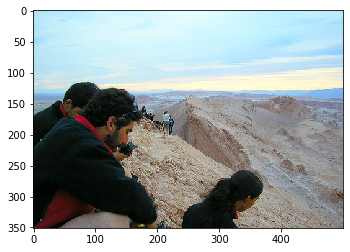

In [78]:
img_id = list(test_image_features.keys())[10]
x = plt.imread(f'{FLICKR8K_DATASET}/{img_id}.jpg')
plt.imshow(x)
plt.show()

In [100]:
captions, log_prob = generate_caption_beam(
    base_model,
    tokenizer,
    test_image_features[img_id].reshape((1, 2048)), 
    max_length, 
    vocab_size, 
    1,
)
t = []
for c, p in zip(captions, log_prob):
    t.append((c, p))
sorted(t, key=lambda x: x[1])

[('man in red shirt is standing in front of mountain', -1.0768248)]

In [101]:
captions, log_prob = generate_caption_beam(
    base_model,
    tokenizer,
    test_image_features[img_id].reshape((1, 2048)), 
    max_length, 
    vocab_size, 
    10,
)
t = []
for c, p in zip(captions, log_prob):
    t.append((c, p))
sorted(t, key=lambda x: x[1])

[('the man in the blue shirt is standing in front of the mountains',
  -0.96945566),
 ('group of people are standing in front of mountain', -0.9595049),
 ('the man in the red shirt is standing in front of the mountains',
  -0.94657654),
 ('group of people stand in front of mountain', -0.9419054),
 ('the man in the blue shirt is standing in front of mountain', -0.9285996),
 ('the man in the red shirt is standing in front of waterfall', -0.91085356),
 ('the man in the red shirt is standing in front of mountain', -0.9032783),
 ('group of people standing in front of waterfall', -0.8824206),
 ('group of people are standing in front of waterfall', -0.870782),
 ('group of people stand in front of waterfall', -0.82130915)]

## Hyperparameter Tuning

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token='<unk>', 
                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_train_captions)
max_length = max(len(t) for t in tokenizer.texts_to_sequences(all_train_captions))
vocab_size = len(tokenizer.index_word) + 1

# Load Glove vectors
glove_dir = 'glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 300

# Get 200-dim dense vector for each of the 1652 words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

34


In [37]:
# index our vocab to assign a number to each word, important for model input.
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocabs:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

# get vocab size to put into embedding layer in the model
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [41]:
ixtoword[1651]

'camels'

In [52]:
tokenizer.texts_to_sequences(['control tuxedos kiddle masks mural boston soft'])

[[1645, 1646, 1, 1651, 1, 1, 1]]

In [51]:
for i in range(1645, 1655):
    print(i, tokenizer.index_word[i])

1645 control
1646 tuxedos
1647 kiddie
1648 stretches
1649 accordion
1650 bone
1651 masks
1652 mural
1653 boston
1654 soft


In [8]:
# Load Glove vectors
glove_dir = 'glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [9]:
max(tokenizer.index_word.keys())

7579

In [10]:
embedding_dim = 300

# Get 200-dim dense vector for each of the 1652 words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [10]:
from keras.optimizers import Adam, RMSprop

hyperparameters = [
    {
        'dropout_rate': 0.5,
        'activation': 'relu',
        'dense_units': 512,
        'gru_layers': 3,
        'lr': 	0.0005,
        'optimizer': Adam,
    },
    {
        'dropout_rate': 0.2,
        'activation': 'relu',
        'dense_units': 256,
        'gru_layers': 3,
        'lr': 	0.001,
        'optimizer': Adam,
    },
    {
        'dropout_rate': 0.4,
        'activation': 'selu',
        'dense_units': 512,
        'gru_layers': 2,
        'lr': 	0.002,
        'optimizer': Adam,
    },
    {
        'dropout_rate': 0.45,
        'activation': 'relu',
        'dense_units': 512,
        'gru_layers': 2,
        'lr': 0.008,
        'optimizer': RMSprop,
    },
    {
        'dropout_rate': 0.1,
        'activation': 'relu',
        'dense_units': 512,
        'gru_layers': 2,
        'lr': 0.001,
        'optimizer': RMSprop,
    },
    {
        'dropout_rate': 0.1,
        'activation': 'relu',
        'dense_units': 256,
        'gru_layers': 1,
        'lr': 	0.003,
        'optimizer': Adam,
    },
    {
        'dropout_rate': 0.1,
        'activation': 'relu',
        'dense_units': 512,
        'gru_layers': 2,
        'lr': 0.001,
        'optimizer': Adam,
    },
]

In [13]:
from keras.layers import LSTM, GRU, Embedding, Dense, Flatten, Dropout, GlobalAveragePooling1D
from keras.layers.merge import add
from keras.models import Model
from keras import Input

dense_units = 300

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(dense_units, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, embeddings_initializer='glorot_uniform',
                    weights=[embedding_matrix])(inputs2)
se2 = GRU(dense_units, return_sequences=True) (se1)
se21 = Dropout(0.3)(se2)
se3 = GRU(dense_units, return_sequences=True) (se21)
se4 = Dropout(0.3)(se3)
se5 = GRU(dense_units, return_sequences=True) (se4)
decoder1 = add([fe2, se5])
decoder2 = Dense(dense_units, activation='relu')(decoder1)
flat = GlobalAveragePooling1D()(decoder2)
outputs = Dense(vocab_size, activation='softmax')(flat)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop')

# summarize model
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 300)      2274000     input_3[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 34, 300)      540900      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 34, 300)      0           gru_1[0][0]                      
____________________________________________________________________________________________

In [11]:
from keras.layers import LSTM, GRU, Embedding, Dense, Flatten, Dropout
from keras.layers.merge import add
from keras.models import Model
from keras import Input


def get_model(dropout_rate, activation, dense_units, lr, gru_layers, optimizer):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(dropout_rate)(inputs1)
    fe2 = Dense(dense_units, activation=activation)(fe1)

    # sequence model
    inputs2 = Input(shape=(max_length,))
    se = Embedding(
        vocab_size, 
        embedding_dim, 
        mask_zero=True,
        weights=[embedding_matrix],
    )(inputs2)
    for i in range(gru_layers-1):
        se = GRU(
            dense_units, 
            dropout=dropout_rate,
            return_sequences=True,
        )(se)
    se2 = GRU(
        dense_units,
        dropout=dropout_rate,
    )(se)

    # decoder model
    decoder1 = add([fe2, se2])
    decoder2 = Dense(dense_units, activation=activation)(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer(lr))
    return model

In [16]:
history = defaultdict(list)

In [13]:
for n, hp in enumerate(hyperparameters):
    if n != 4:
        continue
    print(hp)

{'dropout_rate': 0.1, 'activation': 'relu', 'dense_units': 512, 'gru_layers': 2, 'lr': 0.001, 'optimizer': <class 'keras.optimizers.RMSprop'>}


In [17]:
from collections import defaultdict

epochs = 30
number_pics_per_batch = 32
train_steps = len(train_descriptions) // number_pics_per_batch
validation_steps = len(dev_descriptions) // number_pics_per_batch


for n, hp in enumerate([1]):
#     model = get_model(**hp)
    model_dir = f'final_model_2'
    try:
        os.mkdir(model_dir)
        print('Created dir: ', model_dir)
    except:
        pass

    for i in range(epochs):
        train_generator = data_generator_2(
            train_descriptions, 
            train_image_features, 
            tokenizer,
            max_length, 
            vocab_size,
            number_pics_per_batch,
        )
        dev_generator = data_generator_2(
            dev_descriptions, 
            dev_image_features,
            tokenizer,
            max_length,
            vocab_size,
            number_pics_per_batch,
        )
        hist = model.fit(
            train_generator, 
            validation_data=dev_generator, 
            epochs=1, 
            steps_per_epoch=train_steps,
            validation_steps=validation_steps,
            verbose=1,
        )
        history[f'model_{n}'].append({
            'loss': hist.history['loss'], 
            'val_loss': hist.history['val_loss'],
        })
        model.save(f'./{model_dir}/model_' + str(i) + '.h5')

Epoch 1/1
187/187 [==============================] - 126s 672ms/step - loss: 4.7522 - val_loss: 4.4973
Epoch 1/1
187/187 [==============================] - 126s 673ms/step - loss: 4.3962 - val_loss: 4.2382
Epoch 1/1
187/187 [==============================] - 126s 672ms/step - loss: 4.1498 - val_loss: 4.0702
Epoch 1/1
187/187 [==============================] - 126s 672ms/step - loss: 3.9514 - val_loss: 3.9520
Epoch 1/1
187/187 [==============================] - 125s 671ms/step - loss: 3.7922 - val_loss: 3.9249
Epoch 1/1
187/187 [==============================] - 89s 476ms/step - loss: 3.6616 - val_loss: 3.8187
Epoch 1/1
187/187 [==============================] - 96s 513ms/step - loss: 3.5461 - val_loss: 3.7718
Epoch 1/1
187/187 [==============================] - 115s 616ms/step - loss: 3.4510 - val_loss: 3.7242
Epoch 1/1
187/187 [==============================] - 108s 580ms/step - loss: 3.3597 - val_loss: 3.7182
Epoch 1/1
187/187 [==============================] - 108s 577ms/step - loss

KeyboardInterrupt: 

In [97]:
from keras.layers import LSTM, GRU, Embedding, Dense, Flatten, Dropout
from keras.layers.merge import add
from keras.models import Model
from keras import Input

# feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

# sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(
    vocab_size, 
    embedding_dim, 
    mask_zero=True,
    weights=[embedding_matrix],
)(inputs2)
se2 = GRU(
    512, 
    dropout=0.3,
    return_sequences=True,
)(se1)
se3 = GRU(
    512,
    dropout=0.3,
)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
base_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
base_model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(base_model.summary())

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_74 (InputLayer)           (None, 34)           0                                            
__________________________________________________________________________________________________
input_73 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 34, 300)      2274000     input_74[0][0]                   
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 2048)         0           input_73[0][0]                   
___________________________________________________________________________________________

In [21]:
history['model_0']

[{'loss': [4.753995238673324], 'val_loss': [4.497321128845215]},
 {'loss': [4.398151041817611], 'val_loss': [4.238163471221924]},
 {'loss': [4.151703889555644], 'val_loss': [4.070217609405518]},
 {'loss': [3.9534076998636687], 'val_loss': [3.9520370960235596]},
 {'loss': [3.794118313952315], 'val_loss': [3.9249494075775146]},
 {'loss': [3.6635931153472883], 'val_loss': [3.8187451362609863]},
 {'loss': [3.548058404354136], 'val_loss': [3.7718403339385986]},
 {'loss': [3.4530158504570383], 'val_loss': [3.724193811416626]},
 {'loss': [3.3615617634740484], 'val_loss': [3.7181642055511475]},
 {'loss': [3.2897205552800624], 'val_loss': [3.6863186359405518]},
 {'loss': [3.2187649120147133], 'val_loss': [3.8059277534484863]},
 {'loss': [3.1495213438943104], 'val_loss': [3.6793065071105957]},
 {'loss': [3.0913413975833905], 'val_loss': [3.6905269622802734]},
 {'loss': [3.034947318360126], 'val_loss': [3.804967164993286]}]

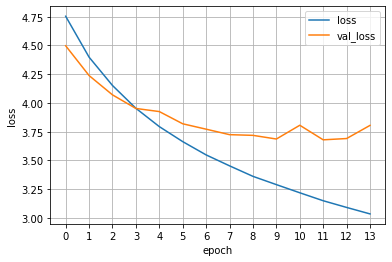

In [24]:
import matplotlib.pyplot as plt 

hist_df = pd.DataFrame(history['model_0'])
plt.plot(list(hist_df['loss']), label='loss')
plt.plot(list(hist_df['val_loss']), label='val_loss')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0, 14, 1))
plt.grid()
plt.show()

In [76]:
from rouge import Rouge

def run_rouge(test_descriptions, predicted_dict):
    rouge = Rouge()

    # get rouge for ref caption 1
    rouge_greedy_1 = dict()
    for image_fileName, reference_captions in test_descriptions.items():
        cand=[' '.join(predicted_dict[image_fileName])]
        ref_cap_reformat = list(list(zip(reference_captions))[0]) 
        rouge_greedy_1[image_fileName] = rouge.get_scores(cand, ref_cap_reformat, avg=True)

    # get rouge for ref caption 2
    rouge_greedy_2 = dict()
    for image_fileName, reference_captions in test_descriptions.items():
        cand=[' '.join(predicted_dict[image_fileName])]
        ref_cap_reformat = list(list(zip(reference_captions))[1])
        rouge_greedy_2[image_fileName] = rouge.get_scores(cand, ref_cap_reformat, avg=True)

    # get rouge for ref caption 3
    rouge_greedy_3 = dict()
    for image_fileName, reference_captions in test_descriptions.items():
        cand=[' '.join(predicted_dict[image_fileName])]
        ref_cap_reformat = list(list(zip(reference_captions))[2])
        rouge_greedy_3[image_fileName] = rouge.get_scores(cand, ref_cap_reformat, avg=True)

    # get rouge for ref caption 4
    rouge_greedy_4 = dict()
    for image_fileName, reference_captions in test_descriptions.items():
        cand=[' '.join(predicted_dict[image_fileName])]
        ref_cap_reformat = list(list(zip(reference_captions))[3])
        rouge_greedy_4[image_fileName] = rouge.get_scores(cand, ref_cap_reformat, avg=True)

    # get rouge for ref caption 5
    rouge_greedy_5 = dict()
    for image_fileName, reference_captions in test_descriptions.items():
        cand=[' '.join(predicted_dict[image_fileName])]
        ref_cap_reformat = list(list(zip(reference_captions))[4])
        rouge_greedy_5[image_fileName] = rouge.get_scores(cand, ref_cap_reformat, avg=True)

    # repeat for all 5 captions by changing [0] to 1, 2, 3, 4 in rer_cap_format
    def average_dicts(dicts):
        result = {}
        for i, d in enumerate(dicts):
            for k, v in d.items():
                update_dict_average(result, k, v, i)
        return result

    def update_dict_average(current, key, update, n):
        if isinstance(update, dict):
            subcurrent = current.setdefault(key, {})
            for subkey, subupdate in update.items():
                update_dict_average(subcurrent, subkey, subupdate, n)
        else:
            current[key] = (current.get(key, 0) * n + update) / (n + 1)

    rouge_avg_1 = {'avg_cap_1': average_dicts(rouge_greedy_1.values())}
    rouge_avg_2 = {'avg_cap_2': average_dicts(rouge_greedy_2.values())}
    rouge_avg_3 = {'avg_cap_3': average_dicts(rouge_greedy_3.values())}
    rouge_avg_4 = {'avg_cap_4': average_dicts(rouge_greedy_4.values())}
    rouge_avg_5 = {'avg_cap_5': average_dicts(rouge_greedy_5.values())}

    cap_1 = pd.DataFrame.from_dict({(i,j): rouge_avg_1[i][j]
                               for i in rouge_avg_1.keys()
                               for j in rouge_avg_1[i].keys()},
                           orient='index')
    cap_2 = pd.DataFrame.from_dict({(i,j): rouge_avg_2[i][j]
                               for i in rouge_avg_2.keys()
                               for j in rouge_avg_2[i].keys()},
                           orient='index')
    cap_3 = pd.DataFrame.from_dict({(i,j): rouge_avg_3[i][j]
                               for i in rouge_avg_3.keys()
                               for j in rouge_avg_3[i].keys()},
                           orient='index')
    cap_4 = pd.DataFrame.from_dict({(i,j): rouge_avg_4[i][j]
                               for i in rouge_avg_4.keys()
                               for j in rouge_avg_4[i].keys()},
                           orient='index')
    cap_5 = pd.DataFrame.from_dict({(i,j): rouge_avg_5[i][j]
                               for i in rouge_avg_5.keys()
                               for j in rouge_avg_5[i].keys()},
                           orient='index')
    frames = [cap_1,cap_2, cap_3, cap_4, cap_5]
    rouge_greedy_all = pd.concat(frames)
    return rouge_greedy_all['f'].groupby(level=1).mean()

## Final model evaluation

The BLEU scores for the final model using greedy search has improvements over the base model.

In [54]:
actual, predicted_greedy = bleu_evalulate(model, test_descriptions, test_image_features, beam_width=1)

Evaluating model with BLEU using Beam Search with 1 beam_width:   6%|▋         | 63/1000 [00:12<02:55,  5.34it/s]/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log
Evaluating model with BLEU using Beam Search with 1 beam_width: 100%|██████████| 1000/1000 [03:10<00:00,  5.26it/s]


BLEU-1: 0.493503
BLEU-2: 0.292305
BLEU-3: 0.205592
BLEU-4: 0.103113


However, with beam search using 3 beam widths is slightly worse than the greedy search.

In [53]:
actual, predicted_beam3 = bleu_evalulate(model, test_descriptions, test_image_features, beam_width=3)

Evaluating model with BLEU using Beam Search with 3 beam_width:   3%|▎         | 26/1000 [00:13<07:53,  2.06it/s]/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log
Evaluating model with BLEU using Beam Search with 3 beam_width: 100%|██████████| 1000/1000 [08:52<00:00,  1.88it/s]


BLEU-1: 0.460906
BLEU-2: 0.280446
BLEU-3: 0.200440
BLEU-4: 0.102660


In [75]:
# create list of keys to zip against predicted
test_image_ids_list = []
for keys in test_descriptions:
    test_image_ids_list.append(keys)

# zip together
predicted_greedy_dict = dict(zip(test_image_ids_list, predicted_greedy))

The same is also true for ROUGE scores as well. The greedy search has slighter better scores than the beam search with 3 beam widths.

In [77]:
run_rouge(test_descriptions, predicted_greedy_dict)

rouge-1    0.210119
rouge-2    0.048486
rouge-l    0.203367
Name: f, dtype: float64

In [78]:
predicted_bbeam_dict = dict(zip(test_image_ids_list, predicted_beam3))
run_rouge(test_descriptions, predicted_bbeam_dict)

rouge-1    0.195609
rouge-2    0.046820
rouge-l    0.191528
Name: f, dtype: float64

Thus, we need to further evaluate with visual inspections.

In [81]:
for i in range(10):
    print("Greedy caption: %s" % ' '.join(list(predicted_greedy_dict.values())[i]))
    print("Best beam caption: %s" % ' '.join(list(predicted_bbeam_dict.values())[i]))
    print()

Greedy caption: man in red shirt is walking down the street
Best beam caption: young boy wearing red shirt is walking down the street

Greedy caption: boy is running through the water
Best beam caption: boy is running through the water

Greedy caption: man in red shirt is walking down the street
Best beam caption: two men are sitting on bench

Greedy caption: white and white dog is running through the grass
Best beam caption: white and white dog is running through the grass

Greedy caption: boy is standing on the edge of the water
Best beam caption: small boy is playing in the water

Greedy caption: black and white dog is running through the grass
Best beam caption: dog is running through the grass

Greedy caption: white and white dog is running through the grass
Best beam caption: dog is running through the grass

Greedy caption: boy is sitting on the bed
Best beam caption: young boy is playing in the grass

Greedy caption: dog is running through the water
Best beam caption: white and